In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout,Reshape,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D,Conv1D,MaxPooling1D
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

test_feature = pd.read_csv('test.csv')
train_data = pd.read_csv('train.csv')
test_feature.head()

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


1.9.0


,id,penalty,l1_ratio,alpha,max_iter,random_state,n_jobs,n_samples,n_features,n_classes,n_clusters_per_class,n_informative,flip_y,scale
0,0,l2,0.690384,0.001,602,890,4,1376,1078,3,4,8,0.049072,40.832757
1,1,elasticnet,0.215088,0.001,522,357,4,598,1528,10,3,11,0.041393,68.611537
2,2,l2,0.217458,0.001,398,105,16,553,1008,8,5,8,0.005987,61.713892
3,3,none,0.120303,0.001,439,586,16,1977,1319,3,4,10,0.002964,58.631194
4,4,none,0.458851,0.010,278,246,4,1826,1530,7,5,8,0.050126,87.315374


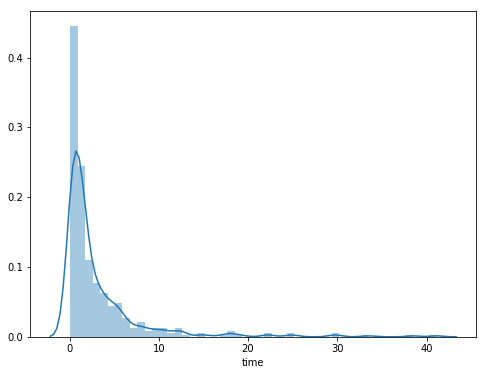

In [2]:
#The distribution of time 
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train_data['time'])

In [3]:
train_data.drop(columns='id',inplace=True)
test_feature.drop(columns='id',inplace=True)

In [4]:
def function(a, b):
    if b == 'elasticnet':
        return a
    else:
        return 0

train_data['l1_ratio']= train_data.apply(lambda x: function(x.l1_ratio,x.penalty),axis = 1)
test_feature['l1_ratio']= test_feature.apply(lambda x: function(x.l1_ratio,x.penalty),axis = 1)

train_data.drop(columns='scale',inplace=True)
test_feature.drop(columns='scale',inplace=True)

train_data.drop(columns='random_state',inplace=True)
test_feature.drop(columns='random_state',inplace=True)

In [5]:
train_data = pd.get_dummies(train_data)
test_feature= pd.get_dummies(test_feature)

In [6]:
def fun2(x):
    if x == -1:
        return 16
    else:
        return x
train_data['n_jobs']= train_data['n_jobs'].apply(lambda x: fun2(x))
test_feature['n_jobs']= test_feature['n_jobs'].apply(lambda x: fun2(x))

In [7]:
train_data['time']= train_data['time'].apply(lambda x: math.log(x))
train_Y = train_data['time']
train_data.drop(columns='time',inplace=True)
train_X = train_data
train_X.head()

,l1_ratio,alpha,max_iter,n_jobs,n_samples,n_features,n_classes,n_clusters_per_class,n_informative,flip_y,penalty_elasticnet,penalty_l1,penalty_l2,penalty_none
0,0.000000,0.0001,417,16,1089,327,4,3,7,0.074798,0,0,0,1
1,0.000000,0.0010,578,1,790,373,4,5,7,0.077781,0,1,0,0
2,0.000000,0.0100,588,2,428,1198,2,5,6,0.030196,0,0,0,1
3,0.000000,0.0010,829,4,877,313,6,5,7,0.057261,0,0,0,1
4,0.395049,0.0010,167,2,216,644,8,5,11,0.073728,1,0,0,0


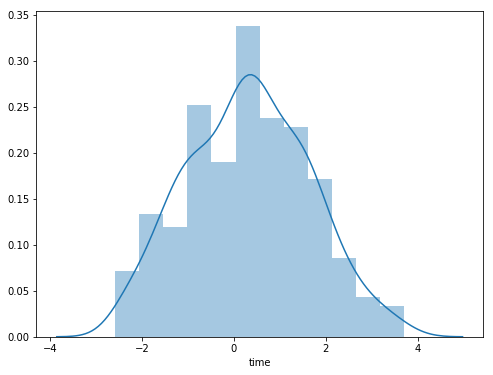

In [8]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train_Y)

In [9]:
def func_c(a,b):
    return a*b
train_data['n_cluster']= train_data.apply(lambda x: func_c(x.n_clusters_per_class,x.n_classes),axis = 1)
test_feature['n_cluster']= test_feature.apply(lambda x: func_c(x.n_clusters_per_class,x.n_classes),axis = 1)


In [10]:
def function( b,c,d,e):
    return b*c*d/e

train_data['y*n_samples']= train_data.apply(lambda x: function(x.n_samples,x.n_features,x.max_iter,x.n_jobs),axis = 1)
test_feature['y*n_samples']= test_feature.apply(lambda x: function(x.n_samples,x.n_features,x.max_iter,x.n_jobs),axis = 1)

In [11]:
numeric_feats = train_data.dtypes[train_data.dtypes != "object"].index
skewed_feats = train_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(15)



Skew in numerical features: 



,Skew
y*n_samples,2.974047
l1_ratio,1.567313
penalty_l2,1.334375
penalty_l1,1.217562
penalty_none,1.094306
n_jobs,1.003699
penalty_elasticnet,0.993824
n_cluster,0.836670
alpha,0.677777
n_clusters_per_class,0.096758


In [12]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    train_data[feat] = boxcox1p(train_data[feat], lam)
    test_feature[feat] = boxcox1p(test_feature[feat], lam)

There are 16 skewed numerical features to Box Cox transform


In [13]:
# train_data.drop(columns='penalty_elasticnet',inplace=True)
# test_feature.drop(columns='penalty_elasticnet',inplace=True)
train_data.drop(columns='penalty_none',inplace=True)
test_feature.drop(columns='penalty_none',inplace=True)

In [14]:
train_data.drop(columns='n_informative',inplace=True)
test_feature.drop(columns='n_informative',inplace=True)
# train_data.drop(columns='flip_y',inplace=True)
# test_feature.drop(columns='flip_y',inplace=True)
train_data.drop(columns='n_samples',inplace=True)
test_feature.drop(columns='n_samples',inplace=True)
# # train_data.drop(columns='n_jobs',inplace=True)
# # test_feature.drop(columns='n_jobs',inplace=True)
train_data.drop(columns='n_features',inplace=True)
test_feature.drop(columns='n_features',inplace=True)
train_data.drop(columns='max_iter',inplace=True)
test_feature.drop(columns='max_iter',inplace=True)

In [15]:
train_X = np.array(train_X)
print(train_X)
mean = train_X.mean(axis=0)
std = train_X.std(axis=0)

max = train_X.max(axis=0)
min = train_X.min(axis=0)

train_X = (train_X -mean) / std
test_feature = (test_feature - mean) / std

[[0.00000000e+00 9.99957503e-05 3.53041926e+00 ... 0.00000000e+00
  3.12823869e+00 6.73019512e+01]
 [0.00000000e+00 9.99575262e-04 7.30463147e-01 ... 0.00000000e+00
  3.85880666e+00 1.07778724e+02]
 [0.00000000e+00 9.95776023e-03 1.19431764e+00 ... 0.00000000e+00
  2.88584647e+00 1.05702181e+02]
 ...
 [0.00000000e+00 9.95776023e-03 1.19431764e+00 ... 0.00000000e+00
  4.74513240e+00 1.12488130e+02]
 [0.00000000e+00 9.95776023e-03 2.60259447e+00 ... 7.30463147e-01
  3.53041926e+00 9.36943894e+01]
 [0.00000000e+00 9.99575262e-04 7.30463147e-01 ... 7.30463147e-01
  1.82033410e+00 1.09773702e+02]]


In [ ]:
def build_model():
  model = keras.Sequential([
#     keras.layers.BatchNormalization(input_shape=(12,)),
    keras.layers.Dense(120, activation=tf.nn.relu,input_shape=(train_data.shape[1],)),
    keras.layers.Dense(120, activation=tf.nn.relu),
    keras.layers.Dense(36, activation=tf.nn.softplus),
#     keras.layers.Dropout(0.01),
    keras.layers.Dense(1)
  ])
  optimizer = tf.train.GradientDescentOptimizer(0.001) 
#   optimizer = tf.train.RMSPropOptimizer(0.0005) 
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 120)               1440      
_________________________________________________________________
dense_1 (Dense)              (None, 120)               14520     
_________________________________________________________________
dense_2 (Dense)              (None, 36)                4356      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 37        
Total params: 20,353
Trainable params: 20,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 2000

# Store training stats
history = model.fit(train_X, train_Y, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,batch_size=100,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [ ]:
def plot_history(history):
  plt.figure()
  plt.xlabel('EPOCHS')
  plt.ylabel('Mean Abs Error')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0, 5])

plot_history(history)

In [ ]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=60)

history = model.fit(train_X, train_Y, epochs=EPOCHS,
                    validation_split=0.1, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

In [ ]:
test_predictions = model.predict(test_feature).flatten()
sub_df = pd.DataFrame(test_predictions,columns = ['time'])
sub_df['time'] = sub_df['time'].apply(lambda x: math.exp(x))
sub_df.to_csv("./5001output.csv", index=True,index_label = 'Id')